In [1]:
"""
@author Ryan Williams
     
     Notebook 6 - Model hyperparameter search

@date June-November, 2021
"""

'\n@author Ryan Williams\n     \n     Notebook 6 - Model hyperparameter search\n\n@date June-October, 2021\n'

# Notebook 6 - Model Hyperparameter Search

**Aim:** The aim of this notebook is to find good hyperparameters for our models and to window and split our datasets.

**Summary:** 
- Set random number generators.
- Import necessary packages.
- Import the datasests.
- Convert into 10 hour windows.
- Split datasets into test / train.
- Save datasets.
- Define some helper functions. 
- Hyperparameter search for Support Vector Machine, saving models.
- Hyperparameter search for Logistic Regressor, saving models.
- Hyperparameter search for Convolutional Neural Network, saving model architecture.
- Hyperparameter search for stacked neural network, saving model architecture.

Seed the random number genrators

In [1]:
# Imports for random number influenced packages
import os  # For accessing environmental features
import numpy as np  # For some maths operations
import random as rn  # For random number gneration
import tensorflow as tf  # For support of deep models
from tensorflow import keras  # For deep model backend

# Set seed value for consistency 
seed_value = 1

# Set Tensorflow to run on CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Set seed for Python environmental variables
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Set seed for numpy and random packages 
np.random.seed(seed_value)
rn.seed(seed_value)

# Set seed for Tensorflow environment 
session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1, 
        inter_op_parallelism_threads=1
)
tf.random.set_seed(seed_value)

# Set seed for Keras backend of Tensorflow 
sess = tf.compat.v1.Session(
        graph=tf.compat.v1.get_default_graph(), 
        config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

2021-12-13 16:32:55.190277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-13 16:32:55.191894: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-13 16:33:31.428604: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-13 16:33:31.521156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-13 16:33:31.521210: W tensorflow/stream_ex

Import necessary packages.

In [2]:
import sys  # System related commands
import glob  # For directory and file operations
import joblib  # For file operations 
import pickle  #  For pickle file operations
import pandas as pd  # For using pandas daraframe
import seaborn as sns  # For figure creation
from io import StringIO  # For terminal operations
import matplotlib.pyplot as plt  # For plotting figures 
from collections import Counter  # For array operations
# Sklearn
from sklearn.svm import SVC  # For our SVM model
from sklearn.pipeline import Pipeline  # For creating model Pipelines
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler  # For standardising data inputs to models
from sklearn.linear_model import LogisticRegression  # For our Logistic Regression model
from sklearn.model_selection import RandomizedSearchCV  # For hyperparmeter search
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc  # Model metrics
from sklearn.metrics import precision_recall_curve, balanced_accuracy_score, average_precision_score  # Model metrics
# Keras
import keras_tuner as kt  # For hyperparameter tuning of deep models
from keras import regularizers  # For regualization layers in deep models
from keras.models import Sequential  # To create our deep models
from keras.layers.merge import concatenate  # To merge models to create our stacked model 
from tensorflow.keras.utils import plot_model  # To construct visual representations of deep models
from keras.layers.convolutional import Conv1D, MaxPooling1D  # Convolutional layers for CNN
from keras.layers import GlobalAveragePooling1D, Bidirectional, LSTM  # More layers for deep models
from keras.layers import Dense, Dropout, BatchNormalization, ReLU, Input  # More layers for deep models

# Prepare Data (only needs to be run once)

Lets import the datasets so they can be used througout this notebook

In [2]:
# Set the size of the data windows.
WINDOW_SIZE = 10
# Set how far past the window we want to label, set to 0 for current window.
PREDICTION_LENGTH = 1
# Set the test train split we want to use.
TRAIN_TEST_SPLIT = 0.7
# Amount of rows windowed between saves - higher values will create less intermediate files but will requrie more memory
SUBSET_SIZE = 50000

In [3]:
# Lets import the datasets.
dataset = pd.read_pickle('./sepsis-detection/data/interim/from Notebook 4/processed_dataset.pkl')
dataset_SIRS = pd.read_pickle('./sepsis-detection/data/interim/from Notebook 5/SIRS_dataset.pkl')
dataset_PCA = pd.read_pickle('./sepsis-detection/data/interim/from Notebook 5/PCA_dataset.pkl')
dataset_FRESH = pd.read_pickle('./sepsis-detection/data/interim/from Notebook 5/FRESH_dataset.pkl')
dataset_sparse = pd.read_pickle('./sepsis-detection/data/interim/from Notebook 4/sparse_processed_dataset.pkl')

# Store all of our datasets within a dictionary, for ease of access.
dataset_dict = {}

# Create a copy to use, dependent on dataset chosen.
dataset_dict['dataset_base'] = dataset.copy()
dataset_dict['dataset_FRESH'] = dataset_FRESH.copy()
dataset_dict['dataset_PCA'] = dataset_PCA.copy()
dataset_dict['dataset_SIRS'] = dataset_SIRS.copy()
dataset_dict['dataset_sparse'] = dataset_sparse.copy()

Helper function to convert data into 10 hour windows labelling for the following hour.

In [5]:
# Helper function, taking a dataframe of a dataset and returning a dataframe of data windows
def window_data (dataset_df):
    # Track all the contineous variables into a array
    time_var = (dataset_df.drop(columns=(['patientID', 'SepsisLabel']), axis=1)).columns

    # Store windows as dataframes in an array as we generate them
    windows_list = []

    # Iterate through each patient, present within the dataset, grouping entries per patient 
    for patient, group in dataset_df.groupby('patientID'):

        # Reset the group's index for ease 
        group = group.reset_index(drop=True)

        # Track how many iterations we have done within current group
        window_iteration = 0

        # while iteration + window length + prediction length is smaller than 
        # the number of readings left for this patient
        while (window_iteration + WINDOW_SIZE + PREDICTION_LENGTH <= len(group)):

            # save the all current window's data for ease of access later on   
            window_data = group.iloc[window_iteration:window_iteration + WINDOW_SIZE]

            # Create a tempary dictionary to store the values we want to save for this window
            current_window = {}

            # Set patientID
            current_window['patientID'] = patient
            
            # Lookup label for the next reading and save that as our label 

            # LOOK AT THIS - meant to get the 11th hour NOT any in the next 10
            next_window_label = group.iloc[window_iteration + WINDOW_SIZE: window_iteration + WINDOW_SIZE + PREDICTION_LENGTH]
            next_window_label = int(any(next_window_label['SepsisLabel']))
            current_window['label'] = next_window_label
            # LOOK AT THIS

            # get all the time variant variables into a array and save them as a feature
            current_window['x_window'] = (window_data[time_var]).values
            
            # Add current window to our list of windows
            windows_list.append(pd.DataFrame([current_window]))

            # Iterate the window forward
            window_iteration = window_iteration + 1

    # Concatenate all the dataframes of windows and return the result
    return (pd.concat(windows_list).reset_index(drop=True))

Helper function to split a dataframe into test train dataframes 

In [5]:
# Randomly select which patients will be in each set
def select_trainers (dataset, split):
    # Create a ranom order of all unique patientIDs 
    patients_training_data = dataset['patientID'].unique()
    np.random.shuffle(patients_training_data)
    # Select a specified ratio of patientIDs to assign to the training set
    trainers = patients_training_data[:int(len(dataset['patientID'].unique())*split)]
    return(trainers)

Main method - window each of our datasets saving subsets

In [7]:
# Main - Window our datasets saving each at subset intervals

# Takes ~15mins to run per dataset 
# Uses ~10GB RAM, if less is avaliable decrease the SUBSET_SIZE

# We have to subset rather than just combine to lower memory usage

# Iterate through each dataset, creating a windowed version for each, saving every 50K rows
for key in dataset_dict:
    print("Started: "+str(key))

    # make subsets every subset amount
    for i in range(1, int(len(dataset_dict[key])/SUBSET_SIZE)):
        # Print status updates 
        if ((i % 10) == 0):
            print("Current iteration: " + str(i))
        current_subset = window_data((dataset_dict[key])[((i-1)*SUBSET_SIZE):i*SUBSET_SIZE])
        current_subset.to_pickle('./sepsis-detection/data/interim/from Notebook 6/'+key+'/'+ key +'_'+ str(i) +'.pkl')
        del current_subset # Delete uneeded variable values to save memory

    # do left over - everything past the last iteration aka the modulo
    print("Saving leftovers") 
    current_subset = window_data((dataset_dict[key])[i*SUBSET_SIZE:])
    current_subset.to_pickle('./sepsis-detection/data/interim/from Notebook 6/'+key+'/'+ key +'_'+ str(i+1) +'.pkl')
    del current_subset # Delete uneeded variable values to save memory
    print("Finished: "+str(key))

Started: dataset_base
Current iteration: 1
Current iteration: 2
Current iteration: 3
Current iteration: 4
Current iteration: 5
Current iteration: 6
Current iteration: 7
Current iteration: 8
Current iteration: 9
Current iteration: 10
Current iteration: 11
Current iteration: 12
Current iteration: 13
Current iteration: 14
Current iteration: 15
Current iteration: 16
Current iteration: 17
Current iteration: 18
Current iteration: 19
Current iteration: 20
Current iteration: 21
Current iteration: 22
Current iteration: 23
Current iteration: 24
Current iteration: 25
Current iteration: 26
Current iteration: 27
Current iteration: 28
Current iteration: 29
Current iteration: 30
Saving leftovers
Finished: dataset_base
Started: dataset_SIRS
Current iteration: 1
Current iteration: 2
Current iteration: 3
Current iteration: 4
Current iteration: 5
Current iteration: 6
Current iteration: 7
Current iteration: 8
Current iteration: 9
Current iteration: 10
Current iteration: 11
Current iteration: 12
Current it

Combine together the windowed subsets then split into test and train sets.

In [21]:


trainers = select_trainers(dataset_dict['dataset_base'], TRAIN_TEST_SPLIT)

# Combine together the windowed subsets then split into test and train sets.

# takes ~6 mins to run
# uses ~12GB of RAM 

# Iterate through each dataset
for key in dataset_dict:
    print("Starting combining:", str(key))

    # Designate directory containing the subsets to combine
    directory = glob.glob('./sepsis-detection/data/interim/from Notebook 6/'+key+'/*.pkl')

    # Read each subset from file and them to a list
    dataset_list = []
    for i, f in enumerate(directory):
        dataset_list.append(pd.read_pickle(f))
    
    # Combine all of the subsets into a single dataframe
    combined_subs = pd.concat(dataset_list)
    combined_subs = combined_subs.reset_index(drop=True)

    print("Finished combining:",str(key))

    del dataset_list # Delete uneeded variable values to save memory
    
    # Split the dataset into test train sets
    print("Splitting into test and train")
 
    # Select patients to be in the training set
    train = (combined_subs)[(combined_subs)['patientID'].isin(trainers)].reset_index(drop=True)
    test = (combined_subs)[~((combined_subs)['patientID'].isin(trainers))].reset_index(drop=True)

    del combined_subs # Delete uneeded variable values to save memory

    # Save our data to disk
    train.to_pickle('./sepsis-detection/data/processed/'+ key +'_train.pkl')
    test.to_pickle('./sepsis-detection/data/processed/'+ key +'_test.pkl')
    print("Finished saving test and train")

Starting combining: dataset_base
Finished combining: dataset_base
Splitting into test and train
Finished saving test and train
Starting combining: dataset_FRESH
Finished combining: dataset_FRESH
Splitting into test and train
Finished saving test and train
Starting combining: dataset_PCA
Finished combining: dataset_PCA
Splitting into test and train
Finished saving test and train
Starting combining: dataset_SIRS
Finished combining: dataset_SIRS
Splitting into test and train
Finished saving test and train
Starting combining: dataset_sparse
Finished combining: dataset_sparse
Splitting into test and train
Finished saving test and train


# Helper Functions

In [4]:
# Helper functions to load and process data 

# Helper function to average the values within a windowed dataset
def avg_window(x):
    average_windows_list = []
    # Iterate through each window
    for window in x:
        # Rotate the values in the 2D array so that we have lists of each feature for the window  
        current_window = list(zip(*window[::-1]))
        feature_list = []
        # iterate through each feature and average them
        for feature in (current_window):   
            feature_list.append(np.mean(feature))
        average_windows_list.append(feature_list)
    del feature_list # delete to save memory usage
    return (average_windows_list)

# Helper function to load in a dataset and average windows for conventional models and calcuate class weights
def load_dataset_for_conven(dataset='base', truncate_ratio=1):
  # Load in pkl files
  train = (pd.read_pickle('./sepsis-detection/data/processed/dataset_'+dataset+'_train.pkl'))
  test = (pd.read_pickle('./sepsis-detection/data/processed/dataset_'+dataset+'_test.pkl'))
  # Truncate and average where needed
  x_train = avg_window((train['x_window'][:int((len(train))*truncate_ratio)]).to_list())
  y_train = (train['label'][:int((len(train))*truncate_ratio)]).to_list()
  x_test = avg_window((test['x_window'][:int((len(test))*truncate_ratio)]).to_list())
  y_test = (test['label'][:int((len(test))*truncate_ratio)]).to_list()
  # Calculate class weights based on this dataset
  weight_for_0 = (1 / Counter(y_train)[0]) * (len(y_train) / 2.0)
  weight_for_1 = (1 / Counter(y_train)[1]) * (len(y_train) / 2.0)
  class_weights = {0: weight_for_0, 1: weight_for_1}
  del train # delete to save memory usage
  del test # delete to save memory usage
  # return values
  return x_train, y_train, x_test, y_test, class_weights

# Helper function to load in a dataset and truncate for deep models 
# also calculating class weights and intial bias
def load_dataset_for_deep(dataset='base', truncate_ratio=1):
  # Load in pkl files
  train = (pd.read_pickle('./sepsis-detection/data/processed/dataset_'+dataset+'_train.pkl'))
  test = (pd.read_pickle('./sepsis-detection/data/processed/dataset_'+dataset+'_test.pkl'))
  # Truncate and convert to numpy arrays
  x_train = np.array((train['x_window'][:int((len(train))*truncate_ratio)]).to_list())
  y_train = np.array((train['label'][:int((len(train))*truncate_ratio)]).to_list())
  x_test = np.array((test['x_window'][:int((len(test))*truncate_ratio)]).to_list())
  y_test = np.array((test['label'][:int((len(test))*truncate_ratio)]).to_list())
  # Calculate class weights based on this dataset
  weight_for_0 = (1 / Counter(y_train)[0]) * (len(y_train) / 2.0)
  weight_for_1 = (1 / Counter(y_train)[1]) * (len(y_train) / 2.0)
  class_weights = {0: weight_for_0, 1: weight_for_1}
  # Calculate inital bias for our deep models using Log distribution
  initial_bias = np.log([Counter(y_train)[1]/Counter(y_train)[0]])
  del train # delete to save memory usage
  del test # delete to save memory usage
  # return values
  return x_train, y_train, x_test, y_test, class_weights, initial_bias


# Helper functions to plot figures

# Helper function used to plot confusion matrixs and print out numbers alongside
def plot_cm(labels, predictions, dataset_type, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title('Confusion matrix @'+str(p)+' for the '+str(dataset_type)+' set.')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

# Helper function used to plot Precision-Recall Curve
def plot_PRC(labels, predictions, dataset_type):
  PRC_AUC = average_precision_score(labels, predictions)
  precision_rate, recall_rate,_ = precision_recall_curve(labels, predictions) 
  plt.figure()
  plt.plot(recall_rate, precision_rate, label='Area Under Curve = %0.2f' % PRC_AUC)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Positive Label Precision-Recall Curve for '+dataset_type+' set.')
  plt.legend(loc="lower right")
  plt.show()

# Helper function used to plot ROC curve
def plot_ROC(labels, predictions, dataset_type):
  ROC_AUC = roc_auc_score(labels, predictions)
  fpr, tpr,_ = roc_curve(labels, predictions) 
  plt.figure()
  plt.plot(fpr, tpr, label='Area Under Curve = %0.2f' % ROC_AUC)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for '+dataset_type+' set.')
  plt.legend(loc="lower right")
  plt.show()

# Helper function used to evaluate the performance of a sklearn models
# plotting confustion matrix, PRC and ROC curves.
def evaluate_conventional(pipe_grid, X_train, y_train, X_test, y_test):

  # Get predictions from the train and test sets
  train_predictions = pipe_grid.predict_proba(X_train)[:,1]
  test_predictions = pipe_grid.predict_proba(X_test)[:,1]

  print('\n ====== Best Metrics ====== ')
  print('Most effective parameter combination: ', pipe_grid.best_params_)
  training_score = np.mean(pipe_grid.cv_results_['mean_train_score'])
  print('Mean average unbalanced accuracy for all tested models: ', training_score)

  # Plot confusion matrixs, PRC and ROC curves for both the training and test sets
  print('\n ====== Training set Metrics ====== ')
  print('Balanced accuracy on training set: ', balanced_accuracy_score(y_train, np.round(train_predictions)))
  print(classification_report(y_train, np.round(train_predictions)))
  plot_cm(y_train, train_predictions,'train')
  plot_PRC(y_train, train_predictions,'train')
  plot_ROC(y_train, train_predictions,'train')

  print('\n ====== Test set Metrics: ====== ')
  print('Balanced accuracy on test set: ', balanced_accuracy_score(y_test, np.round(test_predictions)))
  print(classification_report(y_test, np.round(test_predictions)))
  plot_cm(y_test, test_predictions, 'test')
  plot_PRC(y_test, test_predictions, 'test')
  plot_ROC(y_test, test_predictions, 'test')

# Helper function used to evaluate the performance of a keras model 
# plotting confustion matrix, PRC and ROC curves.
def evaulate_keras_model(model, x_train, y_train, x_test, y_test):

  train_predictions = model.predict(x_train, batch_size=BATCH_SIZE)
  test_predictions = model.predict(x_test, batch_size=BATCH_SIZE)

  # Plot confusion matrixs, PRC and ROC curves for both the training and test sets
  print('\n ====== Training set Metrics ====== ')
  print('Balanced accuracy on training set: ', balanced_accuracy_score(y_train, np.round(train_predictions)))
  print(classification_report(y_train, np.round(train_predictions)))
  plot_cm(y_train, train_predictions,'train')
  plot_PRC(y_train, train_predictions,'train')
  plot_ROC(y_train, train_predictions,'train')

  print('\n ====== Test set Metrics: ====== ')
  print('Balanced accuracy on test set: ', balanced_accuracy_score(y_test, np.round(test_predictions)))
  print(classification_report(y_test, np.round(test_predictions)))
  plot_cm(y_test, test_predictions, 'test')
  plot_PRC(y_test, test_predictions, 'test')
  plot_ROC(y_test, test_predictions, 'test')

# Helper function for capturing data printed to terminal
# https://stackoverflow.com/questions/16571150/how-to-capture-stdout-output-from-a-python-function-call
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

# Conventional Models

Define some constants

In [3]:
# These can be overwritten later on for ease, but we will set them default here
TRUNCATE_RATIO = 0.1  # Use to run searches with subsets of the data
CV_FOLDS = 3  # Number of folds used in cross validation of random search 
N_ITER = 3   # How many iterations of the random search

# SVM

Lets do some brief testing to find good hyperparameter ranges.

In [6]:
# Lets run tests to find good hyperameter ranges

# Lets use small amounts of data and folds for this quick testing
TRUNCATE_RATIO = 0.02
CV_FOLDS = 2

x_train, y_train, x_test, y_test, class_weights  = load_dataset_for_conven('base', TRUNCATE_RATIO)

# Create pipeline with scaler and our classifier, a pipeline helps us with automation and standardisation 
svm_pipe = Pipeline([('s', StandardScaler()), ('clf', SVC(class_weight=class_weights, probability=True, random_state=seed_value))])

# Define different ranges to test
parameters_kernel_test = {'clf__kernel': ['rbf', 'linear', 'poly']}

parameters_gamma_test = [{'clf__kernel': ['rbf'], 
                    'clf__gamma': [100.0, 10.0, 1.0, 0.1, 0.01, 0.001]
                    }]

parameters_C_test = [{'clf__kernel': ['rbf'], 
                    'clf__gamma': [0.1], 
                    'clf__C': [100.0, 10.0, 1.0, 0.1, 0.01, 0.001],
                    }]

# Define the gridsearch object, with our pipe, hyperparameters
# CHANGE parameter grid to parse in here based on different tests 
svm_gs = GridSearchCV(svm_pipe, parameters_C_test, scoring='precision', cv=CV_FOLDS, n_jobs=-1, return_train_score=True)
# Run the gridsearch with our pipeline on our training data 
svm_gs.fit(x_train, y_train)

print('Most effective parameter combination: ', svm_gs.best_params_)

Random Search for Hyperparameters!

In [9]:
# Set amount of data to use and number of folds
TRUNCATE_RATIO = 0.1
CV_FOLDS = 5
N_ITER = 3

# Load in a subset of the data that will run in a reasonable timeframe 
x_train, y_train, x_test, y_test, class_weights  = load_dataset_for_conven('base', TRUNCATE_RATIO)

# Create pipeline with scaler and our classifier, a pipeline helps us with automation and standardisation 
svm_pipe = Pipeline([('s', StandardScaler()), ('clf', SVC(class_weight=class_weights, random_state=seed_value, probability=True))])

# Define all hyper parameter values we will test in our hyper parameter search
parameters_grid = [{'clf__kernel': ['rbf'], 
                    'clf__gamma': [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05],
                    'clf__C': [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
                    }]

# Define the randomsearch object, with our pipe, hyperparameters and parameters
svm_rs = RandomizedSearchCV(svm_pipe, parameters_grid, random_state=seed_value, scoring='precision', cv=CV_FOLDS,  n_iter=N_ITER, return_train_score=True, refit=True, n_jobs=-1)
 
# Run the randomsearch with our pipeline on our training data 
svm_rs.fit(x_train, y_train)

# Save our model to file so it can be used in Notebook 7
joblib.dump(svm_rs.best_params_, './sepsis-detection/models/conven/SVM_model.pkl', compress=1)

# Create and show metrics for the best model
evaluate_conventional(svm_rs, x_train, y_train, x_test, y_test)

# 0.3 / cv 5/ iter 3 took over 185mins and didnt finish


KeyboardInterrupt: 

# Logistic Regression

Lets do some brief testing to find good hyperparameter ranges.

In [6]:
# Lets run tests to find good hyperameter ranges

# Lets use small amounts of data and folds for this quick testing
TRUNCATE_RATIO = 0.3
CV_FOLDS = 3

x_train, y_train, x_test, y_test, class_weights  = load_dataset_for_conven('base', TRUNCATE_RATIO)

# Create pipeline with scaler and our classifier, a pipeline helps us with automation and standardisation 
lr_pipe = Pipeline([('s', StandardScaler()), ('clf', LogisticRegression(class_weight=class_weights, random_state=seed_value, max_iter=len(x_train)))])

parameters_solver_test = [{'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]

parameters_C_and_pen_test = [{'clf__solver': ['sag'],
                    'clf__C': [100, 10, 1.0, 0.1, 0.01],
                    'clf__penalty': ['l2', 'none']
                    }]                 

# Define the gridsearch object, with our pipe, hyperparameters and grid parameters
lr_gs = GridSearchCV(lr_pipe, parameters_C_and_pen_test, scoring='precision', cv=CV_FOLDS, n_jobs=-1, return_train_score=True)

# Run the gridsearch with our pipeline on our training data 
lr_gs.fit(x_train, y_train)

print('Most effective parameter combination: ', lr_gs.best_params_)

/mnt/e/UNI WORK/Year 4 - Masters/MastersProject/Code/sepsis-detection/sepsis-detection-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/e/UNI WORK/Year 4 - Masters/MastersProject/Code/sepsis-detection/sepsis-detection-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/e/UNI WORK/Year 4 - Masters/MastersProject/Code/sepsis-detection/sepsis-detection-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/e/UNI WORK/Year 4 - Masters/MastersProject/Code/sepsis-detection/sepsis-detection-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
 

KeyboardInterrupt: 

Random Search for Hyperparameters!


 ====== Best Metrics ====== 
Most effective parameter combination:  {'clf__solver': 'sag', 'clf__penalty': 'l2', 'clf__C': 280}
Mean average unbalanced accuracy for all tested models:  0.08802030064045302

 ====== Training set Metrics ====== 
Balanced accuracy on training set:  0.8232466825221961
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    789392
           1       0.09      0.81      0.16     15437

    accuracy                           0.84    804829
   macro avg       0.54      0.82      0.53    804829
weighted avg       0.98      0.84      0.89    804829



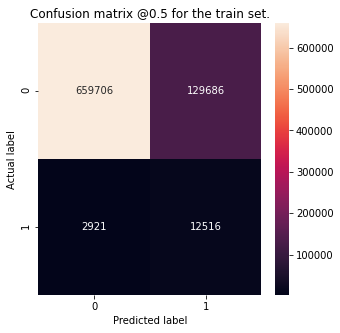

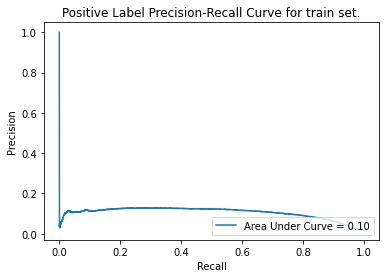

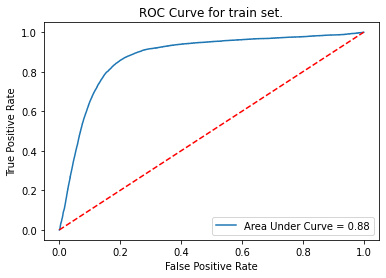


 ====== Test set Metrics: ====== 
Balanced accuracy on test set:  0.8207923952942306
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    338512
           1       0.08      0.81      0.15      6174

    accuracy                           0.84    344686
   macro avg       0.54      0.82      0.53    344686
weighted avg       0.98      0.84      0.90    344686



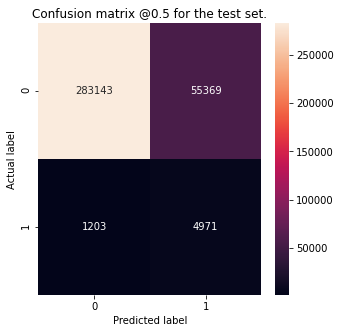

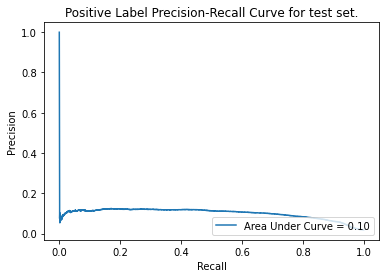

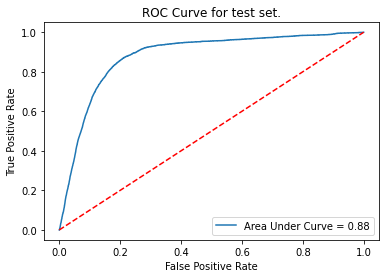

In [7]:
N_ITER = 15
CV_FOLDS = 10

x_train, y_train, x_test, y_test, class_weights  = load_dataset_for_conven('base')

# Create pipeline with scaler and our classifier, a pipeline helps us with automation
# and standardisation 
lr_pipe = Pipeline([('s', StandardScaler()), ('clf', LogisticRegression(class_weight=class_weights, random_state=seed_value, max_iter=len(x_train)))])

# Define all hyper parameter values we will test in our hyper parameter search
parameters_grid = [{'clf__solver': ['sag'],
                    'clf__C': list(range(20, 500, 20)),
                    'clf__penalty': ['l2']
                    }]                 

# Define the gridsearch object, with our pipe, hyperparameters and grid parameters
lr_rs = RandomizedSearchCV(lr_pipe, parameters_grid, random_state=seed_value, scoring='precision', cv=CV_FOLDS,  n_iter=N_ITER, return_train_score=True, refit=True, n_jobs=-1)
 
# Run the gridsearch with our pipeline on our training data 
lr_rs.fit(x_train, y_train)

# Due to our use of a Pipeline, it is best to save the pipeline parameters,
# this will make recreating our model easier in Notebook 7
joblib.dump(lr_rs.best_params_, './sepsis-detection/models/conven/lr_model.pkl', compress=1) 

# Create and show metrics for the best model
evaluate_conventional(lr_rs, x_train, y_train, x_test, y_test)

# all data / N_ITER = 15 / CV_FOLDS = 10 - 65mins

# Deep models

Define some constants, prep some data

In [5]:
# For training
BATCH_SIZE = 1024
EPHOCS = 10
VERBOSE = 0

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]

precision_callbacks = [keras.callbacks.EarlyStopping(monitor='precision', patience=10, mode='max', restore_best_weights=True)]
tp_callbacks = [keras.callbacks.EarlyStopping(monitor='tp', patience=10, mode='max', restore_best_weights=True)]

# CNN

Search for a good network structure

In [9]:
# Function used to create different CNN models with different hyperparameters
# Referenced by a Keras Tuner Object  
def CNN_search(hp):
	input_layer = tf.keras.Input(shape=(10, 12))
	x = input_layer
	# Upto 5 Convolutional blocks
	for i in range(hp.Int('conv_blocks', 2, 5, step=1)):
		# Filters in range 32-128
		filters = hp.Int('filters_' + str(i), 32, 128, step=32)
		# Filters in sizes 1,3,5,10
		kernels = hp.Choice('kernels_' + str(i), values=[1,3,5,10])
		# Construct Convlutional block with specified ranges
		for _ in range(2):
			x = Conv1D(filters=filters, kernel_size=kernels, padding='same')(x)
			x = tf.keras.layers.BatchNormalization()(x)
			x = tf.keras.layers.ReLU()(x)
	# Global average normalisation layer
	x = keras.layers.GlobalAveragePooling1D()(x)
	# Add dense layer with variable hidden layers in range 10-150
	x = tf.keras.layers.Dense(hp.Int('hidden_size', 10, 150, step=10), activation='relu')(x)
	# Dropout layer to reduce overfitting
	x = keras.layers.Dropout(.9)(x)
	# Initize output layer with initial bias
	output_layer = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
	model = tf.keras.Model(input_layer, output_layer)
	# Compile model, with range of learning rate
	model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')), 
		loss='BinaryCrossentropy', metrics=METRICS)
	return model

# Allow for easy alteration for testing
TRUNCATE_RATIO = 1
MAX_TRIALS = 5

# 104 mins - all data with 5 max trials / 10 training ephocs

# Import data, setting appropate class weights and bias
x_train, y_train, x_test, y_test, class_weights, initial_bias = load_dataset_for_deep('base', TRUNCATE_RATIO)

# Construct Keras Tuner object with RandomSearch, aiming to produce models with low loss
tuner_obj = kt.Objective('loss', direction='min')
tuner = kt.RandomSearch(CNN_search, objective=tuner_obj, max_trials=MAX_TRIALS, directory='./sepsis-detection/data/interim/from Notebook 6/deep_hp_search/CNN/', project_name='hp_search', overwrite=True)

# Run the search for hyperparameters
tuner.search(x_train, y_train, epochs=10, validation_split=0.15, class_weight=class_weights, batch_size=BATCH_SIZE, callbacks=precision_callbacks) 

# Save architecture so it can be replicated in Notebook 7
with Capturing() as model_structure:
    tuner.results_summary(1)
with open('./sepsis-detection/models/deep/cnn_structure.pickle', 'wb') as handle:
    pickle.dump(list(model_structure), handle, protocol=pickle.HIGHEST_PROTOCOL)

Trial 5 Complete [00h 12m 31s]
loss: 0.26231062412261963

Best loss So Far: 0.26231062412261963
Total elapsed time: 01h 44m 22s
INFO:tensorflow:Oracle triggered exit


Lets find ideal number of training ephocs

Best epoch: 48

 ====== Training set Metrics ====== 
Balanced accuracy on training set:  0.8662968338586554
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     78462
           1       0.15      0.86      0.25      2020

    accuracy                           0.87     80482
   macro avg       0.57      0.87      0.59     80482
weighted avg       0.97      0.87      0.91     80482



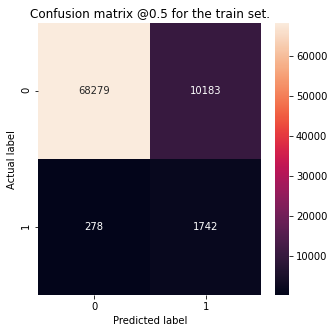

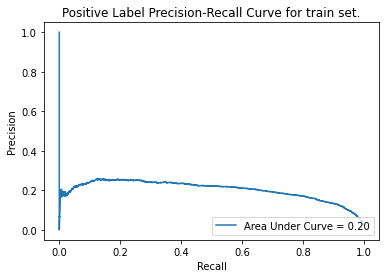

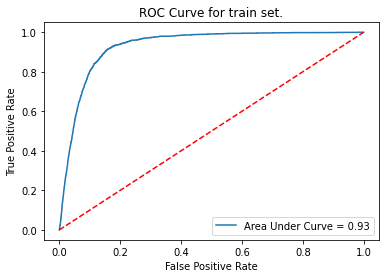


 ====== Test set Metrics: ====== 
Balanced accuracy on test set:  0.8218316464322521
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     33676
           1       0.12      0.78      0.20       792

    accuracy                           0.86     34468
   macro avg       0.56      0.82      0.56     34468
weighted avg       0.97      0.86      0.91     34468



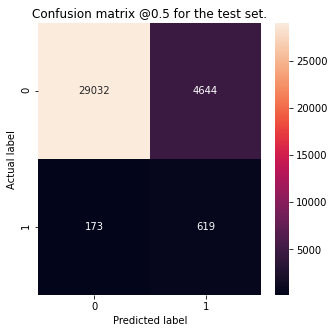

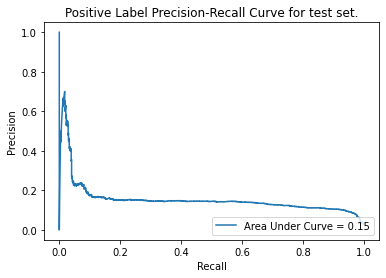

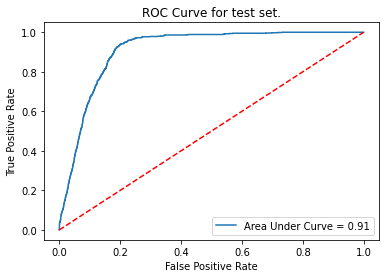

In [10]:
# We will used a subset here to save time
TRUNCATE_RATIO = 0.1
x_train, y_train, x_test, y_test, class_weights, initial_bias = load_dataset_for_deep('base', TRUNCATE_RATIO)

# Rebuild the optimal model and run, looking for the best performining ephoc
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, verbose=VERBOSE, class_weight=class_weights, batch_size=BATCH_SIZE)
val_acc_per_epoch = history.history['precision']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

# Rebuild the optimal model and run for the optimal amount of ephocs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=best_epoch, verbose=VERBOSE, class_weight=class_weights, batch_size=BATCH_SIZE)

# Lets save the model so it can be used in our SNN
model.save('./sepsis-detection/data/interim/from Notebook 6/SNN members/cnn_model.h5')

# Lets save a visual representation of our model
plot_model(model, show_shapes=True, to_file='./sepsis-detection/notebooks/Notebook 6 - Model hyperparameter search/figures/CNN.png')

# Lets see the best version
evaulate_keras_model(model, x_train, y_train, x_test, y_test)

# SNN Members - MLP

In [11]:
# Implementaion based on: https://github.com/hfawaz/ijcnn19ensemble/blob/master/src/classifiers/mlp.py
# Returns a MLP model, with specified structure.
def MLP_builder(no_features, starting_bias):
	input_layer = keras.layers.Input((10,no_features))
	# flatten/reshape because when multivariate all should be on the same axis 
	input_layer_flattened = keras.layers.Flatten()(input_layer)
	layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened)
	layer_1 = keras.layers.Dense(500, activation='relu')(layer_1)
	layer_2 = keras.layers.Dropout(0.2)(layer_1)
	layer_2 = keras.layers.Dense(500, activation='relu')(layer_2)
	layer_3 = keras.layers.Dropout(0.2)(layer_2)
	layer_3 = keras.layers.Dense(500, activation='relu')(layer_3)
	output_layer = keras.layers.Dropout(0.3)(layer_3)
	output_layer = keras.layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(starting_bias))(output_layer)
	model = keras.models.Model(inputs=input_layer, outputs=output_layer)
	model.compile(loss='binary_crossentropy', optimizer='Adam',metrics=METRICS)
	return model

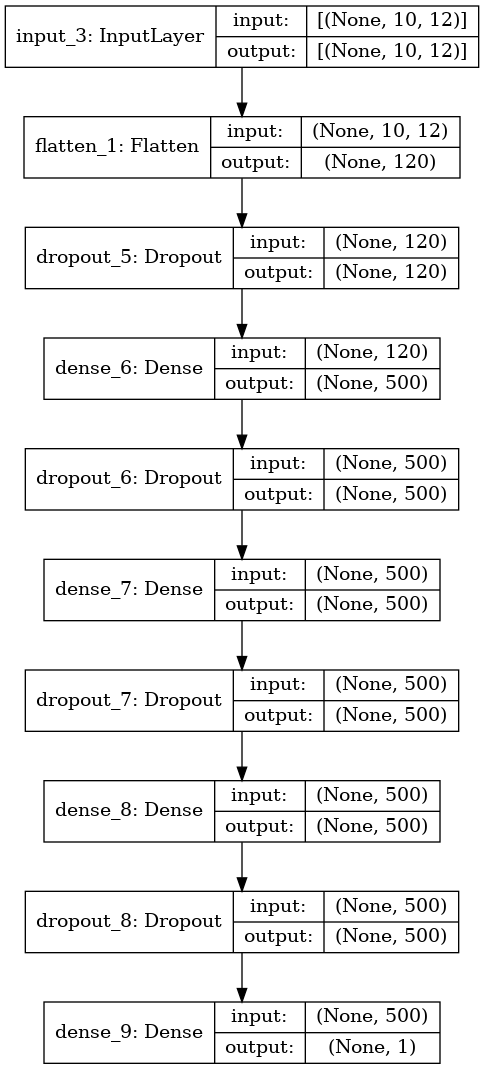

In [13]:
# We will only use a subset of the data to save time
x_train, y_train, x_test, y_test, class_weights, initial_bias = load_dataset_for_deep('base', 0.3)

# Make model
model = MLP_builder(12, initial_bias)

# Fit model to our data 
history = model.fit(x_train, y_train, batch_size=1024, epochs=50, verbose=0, class_weight=class_weights)

# Lets inspect its performance
#evaulate_keras_model(model, x_train, y_train, x_test, y_test)

# Lets save the model so it can be used in our SNN
model.save('./sepsis-detection/data/interim/from Notebook 6/SNN members/mlp_model.h5')

# Lets save a visual representation of our model
plot_model(model, show_shapes=True, to_file='./sepsis-detection/notebooks/Notebook 6 - Model hyperparameter search/figures/MLP.png')

# 7 mins to train with all data and 50 ephocs

# SNN Members - FCN

In [14]:
# Based on implementaion from: https://github.com/hfawaz/ijcnn19ensemble/blob/master/src/classifiers/fcn.py
# Returns a MLP model, with specified structure.
def FCN_builder(no_features, starting_bias):
	input_layer = keras.layers.Input((10,no_features))
	conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
	conv1 = BatchNormalization()(conv1)
	conv1 = keras.layers.Activation(activation='relu')(conv1)
	conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
	conv2 = BatchNormalization()(conv2)
	conv2 = keras.layers.Activation('relu')(conv2)
	conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
	conv3 = BatchNormalization()(conv3)
	conv3 = keras.layers.Activation('relu')(conv3)
	gap_layer = GlobalAveragePooling1D()(conv3)
	output_layer = Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(starting_bias))(gap_layer)
	model = keras.models.Model(inputs=input_layer, outputs=output_layer)
	model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics=METRICS)
	return model 

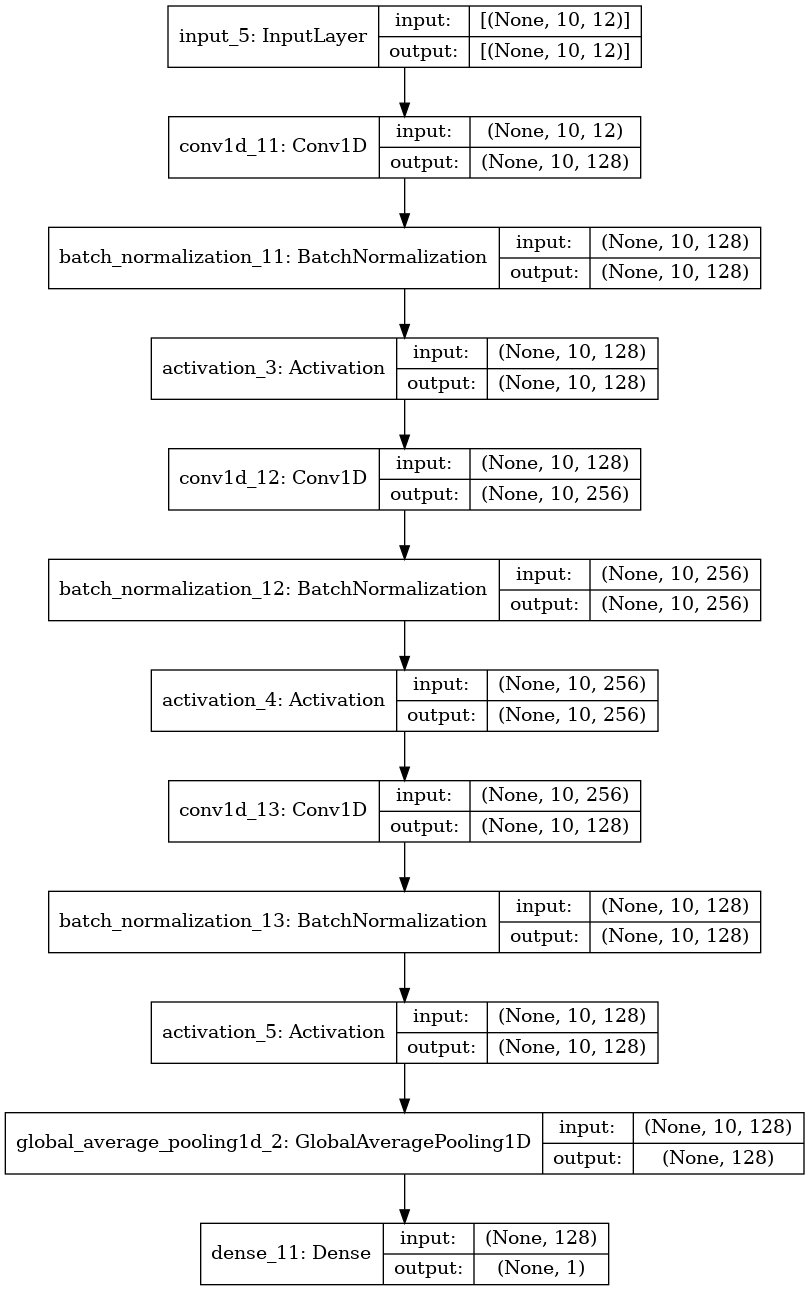

In [16]:
# We will only use a subset of the data to save time
x_train, y_train, x_test, y_test, class_weights, initial_bias = load_dataset_for_deep('base', 0.3)

# Make model
model = FCN_builder(12, initial_bias)

# Fit model to our data 
history = model.fit(x_train, y_train, batch_size=1024, epochs=50, verbose=0, class_weight=class_weights)

# Lets inspect its performance
#evaulate_keras_model(model, x_train, y_train, x_test, y_test)

# Lets save the model so it can be used in our SNN
model.save('./sepsis-detection/data/interim/from Notebook 6/SNN members/fcn_model.h5')

# Lets save a visual representation of our model
plot_model(model, show_shapes=True, to_file='./sepsis-detection/notebooks/Notebook 6 - Model hyperparameter search/figures/FCN.png')

# took 94mins to train

# SNN Ensemble 

Trial 3 Complete [00h 03m 10s]
loss: 0.4541541337966919

Best loss So Far: 0.4462898075580597
Total elapsed time: 00h 10m 35s
INFO:tensorflow:Oracle triggered exit


Epoch 1/5
393/393 [==============================] - 31s 75ms/step - loss: 0.6020 - tp: 5676.0000 - fp: 52635.0000 - tn: 381171.0000 - fn: 3174.0000 - accuracy: 0.8739 - precision: 0.0973 - recall: 0.6414 - auc: 0.7829 - prc: 0.1021
Epoch 2/5
393/393 [==============================] - 28s 72ms/step - loss: 0.4486 - tp: 6320.0000 - fp: 59984.0000 - tn: 334276.0000 - fn: 1834.0000 - accuracy: 0.8464 - precision: 0.0953 - recall: 0.7751 - auc: 0.8701 - prc: 0.1225
Epoch 3/5
393/393 [==============================] - 28s 72ms/step - loss: 0.4480 - tp: 6394.0000 - fp: 62852.0000 - tn: 331408.0000 - fn: 1760.0000 - accuracy: 0.8394 - precision: 0.0923 - recall: 0.7842 - auc: 0.8698 - prc: 0.1249
Epoch 4/5
393/393 [==============================] - 28s 72ms/step - loss: 0.4501 - tp: 6406.0000 - fp: 64598.0000 - tn: 329662.0000 - fn: 1748.0000 - accuracy: 0.8351 - precision: 0.0902 - recall: 0.7856 - auc: 0.8689 - prc: 0.1233
Epoch 5/5
393/393 [==============================] - 28s 72ms/step -

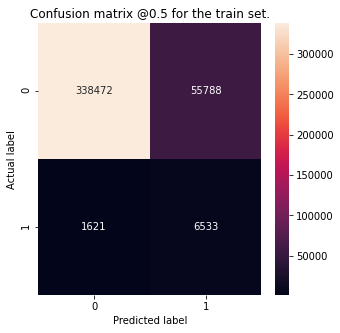

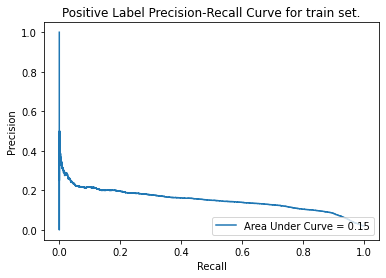

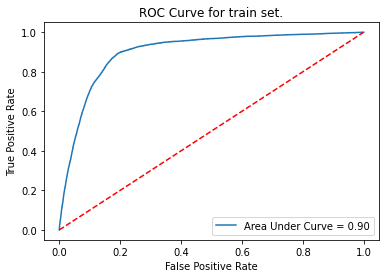


 ====== Test set Metrics: ====== 
Balanced accuracy on test set:  0.8119542325686173
              precision    recall  f1-score   support

           0       0.99      0.87      0.93    169278
           1       0.09      0.76      0.17      3065

    accuracy                           0.87    172343
   macro avg       0.54      0.81      0.55    172343
weighted avg       0.98      0.87      0.91    172343



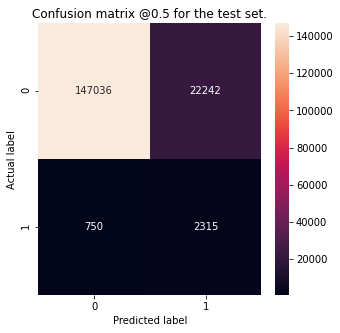

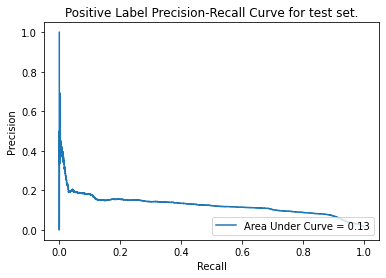

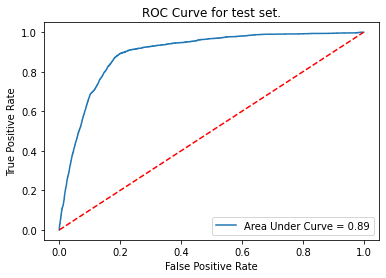

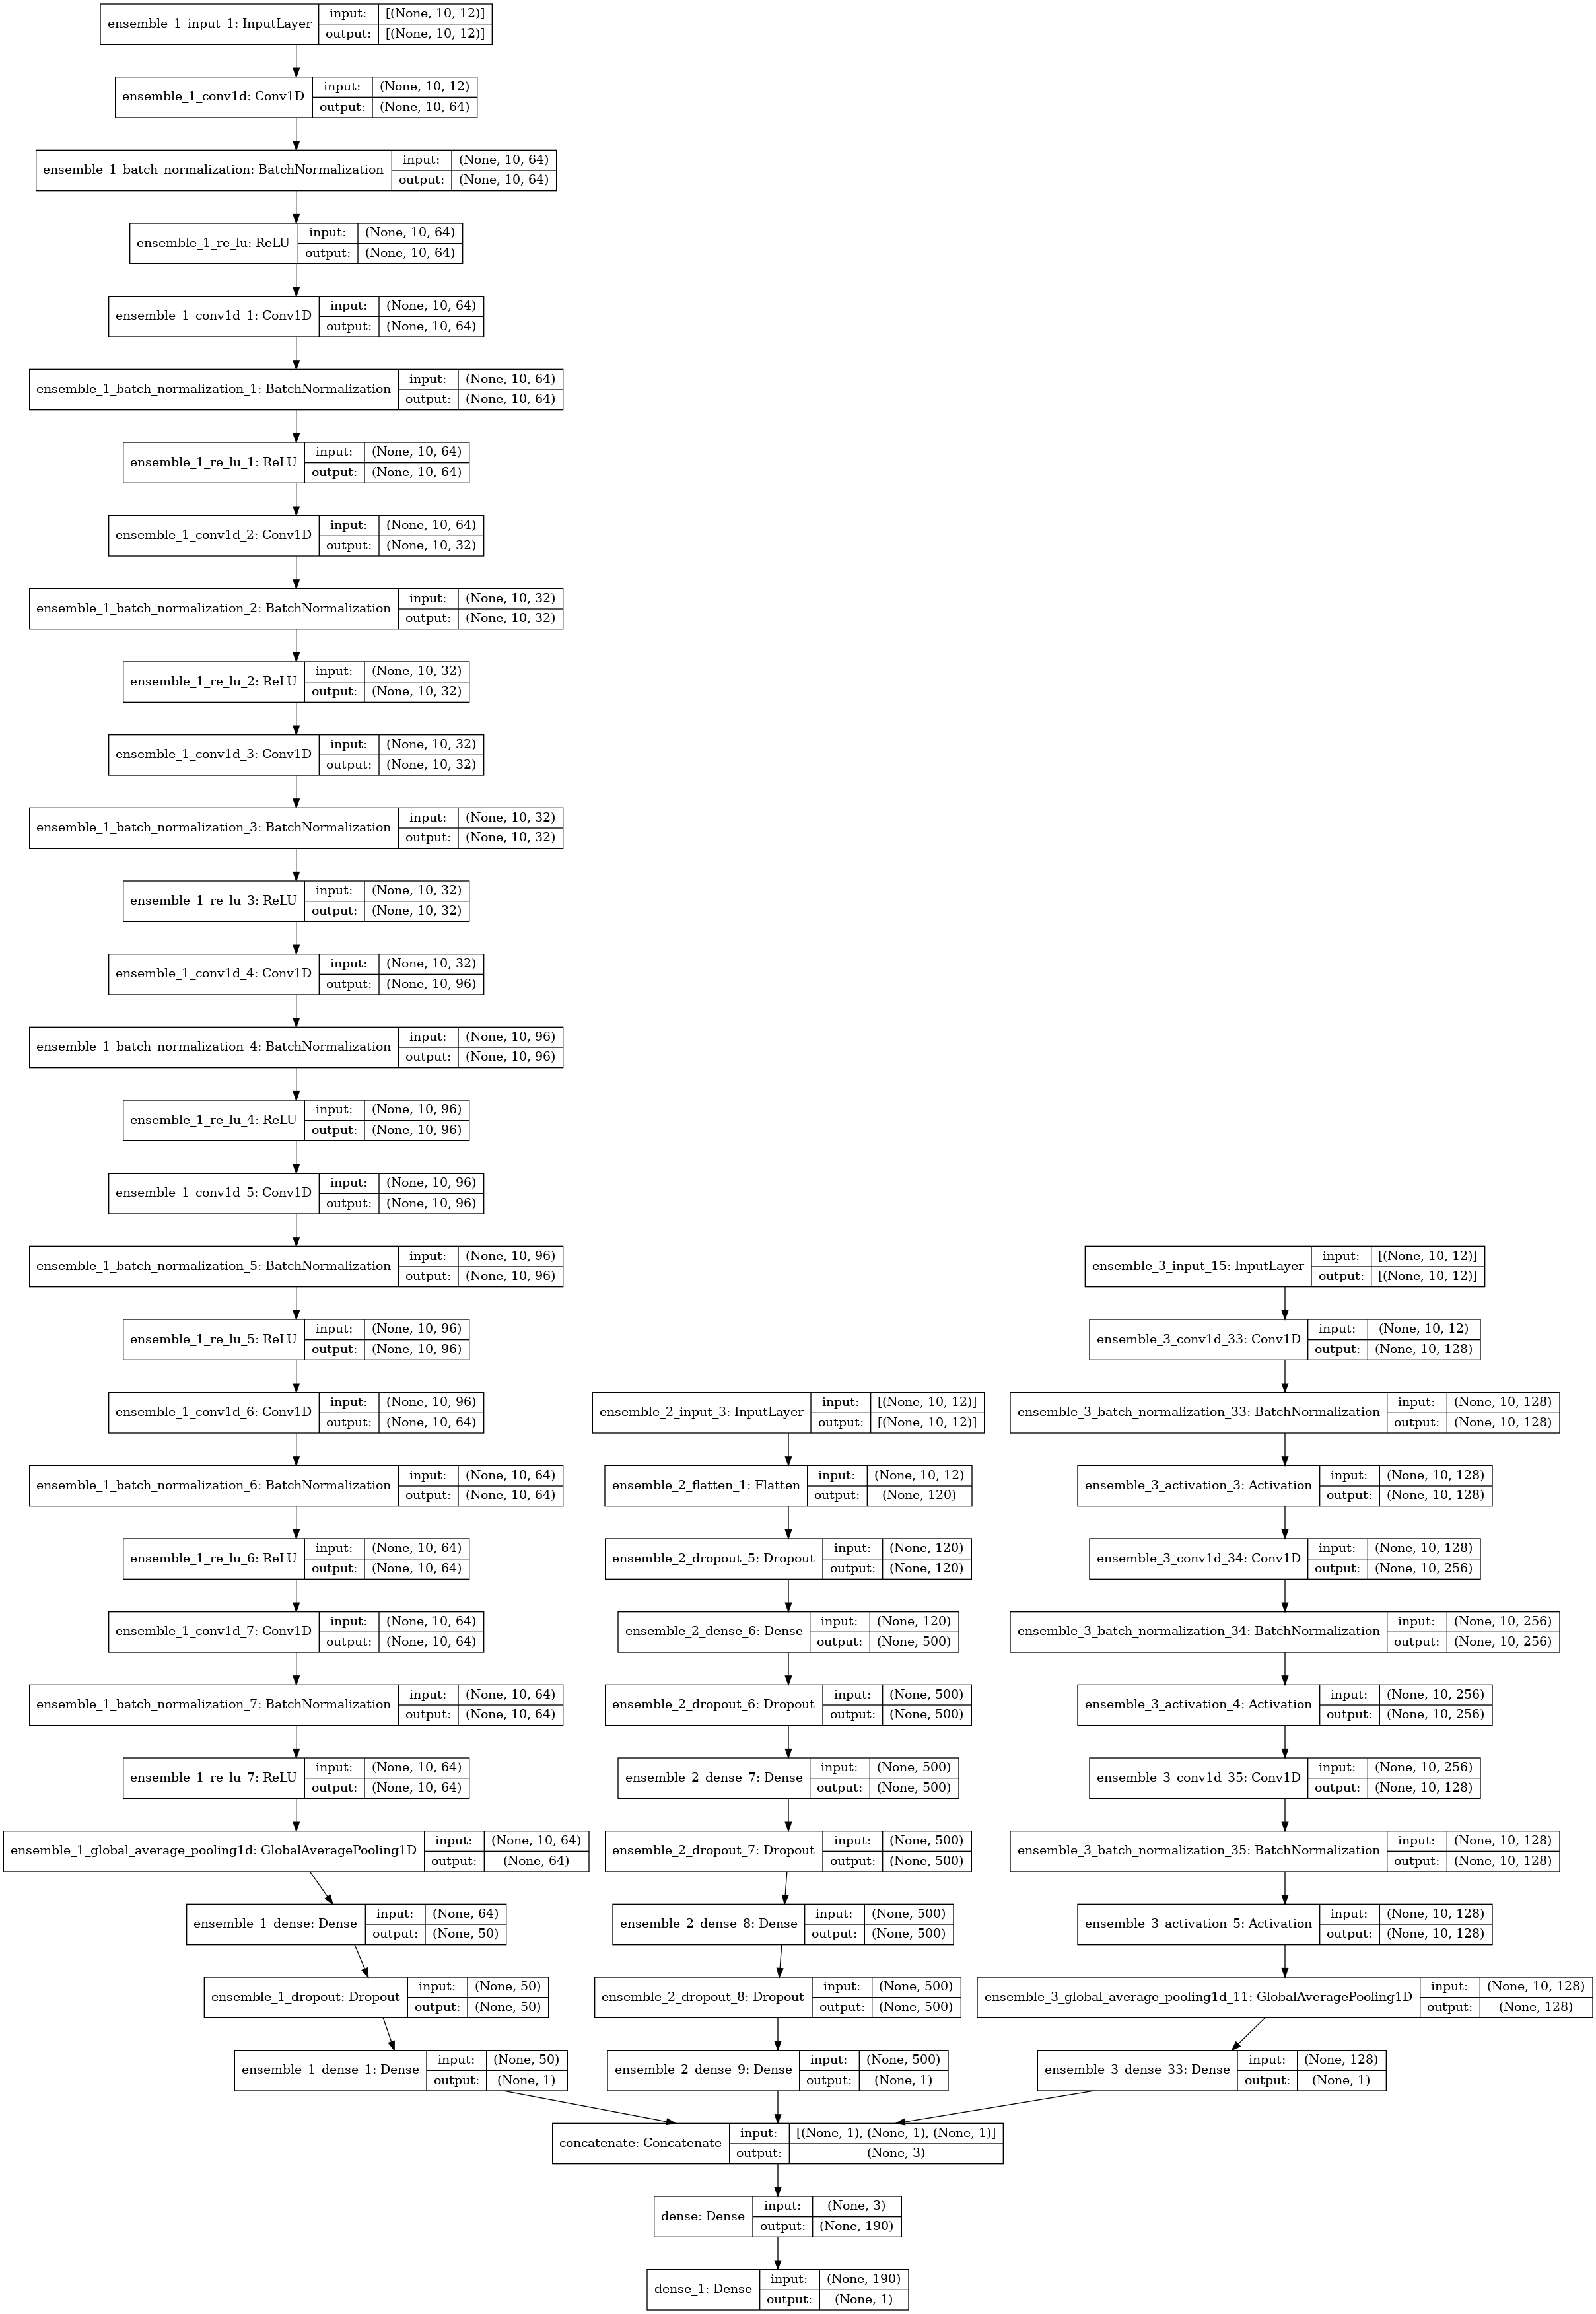

In [8]:
def stacked_search(hp):

	# Use our previously defined models
	member_models = [] 
	member_models.append(keras.models.load_model('./sepsis-detection/data/interim/from Notebook 6/SNN members/cnn_model.h5'))
	member_models.append(keras.models.load_model('./sepsis-detection/data/interim/from Notebook 6/SNN members/mlp_model.h5'))
	member_models.append(keras.models.load_model('./sepsis-detection/data/interim/from Notebook 6/SNN members/fcn_model.h5'))

	# For each model we rename the layers and set them to not be able to train
	for i in range(len(member_models)):
		model = member_models[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# renaming to avoids unique name issues
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

	# Define multi-headed input to allow each model to take a whole dataset as an input
	ensemble_visible = [model.input for model in member_models]

	# Merge the outputs of each model,
	ensemble_outputs = [model.output for model in member_models]
	merge = concatenate(ensemble_outputs)
	
	# Define a hidden layer to be able to take and intepret the outputs from the member models 
	# define a search for the number of internal params
	hidden = Dense(hp.Int('hidden_size', 10, 250, step=10), activation='relu')(merge)

	# Define our output layer
	output = Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias))(hidden)
	model = keras.Model(inputs=ensemble_visible, outputs=output)

	# Compile model
	model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics=METRICS)

	return model 
	
# 16mins .5 / 5 / 3

# Allow for easy alteration for testing
EPHOCS = 10
MAX_TRIALS = 5

# Import data, setting appropate class weights and bias
x_train, y_train, x_test, y_test, class_weights, initial_bias = load_dataset_for_deep('base', 0.5)

# Duplicate our dataset so it can be read evenly by each member model
x_train = [x_train for _ in range(3)]
x_test = [x_test for _ in range(3)]

# Construct Keras Tuner object with RandomSearch, aiming to produce models with low loss
tuner_obj = kt.Objective('loss', direction='min')
tuner = kt.RandomSearch(stacked_search, objective=tuner_obj, max_trials=MAX_TRIALS, directory='./sepsis-detection/data/interim/from Notebook 6/deep_hp_search/SNN/', project_name='hp_search', overwrite=True)

# Run the search for hyperparameters
tuner.search(x_train, y_train, epochs=10, validation_split=0.1, class_weight=class_weights, batch_size=BATCH_SIZE, callbacks=precision_callbacks) 

# Lets save the structure so it can be replicated easily within Notebook 7
with Capturing() as model_structure:
    tuner.results_summary(1)
with open('./sepsis-detection/models/deep/snn_structure.pickle', 'wb') as handle:
    pickle.dump(list(model_structure), handle, protocol=pickle.HIGHEST_PROTOCOL)

# Rebuild the best model from the optimal hyperparameters and evaluate it to see how good it is
best_hps=tuner.get_best_hyperparameters(num_trials=5)[0]
model = tuner.hypermodel.build(best_hps)
hist = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPHOCS, verbose=1, class_weight=class_weights, callbacks=tp_callbacks)
evaulate_keras_model(model, x_train, y_train, x_test, y_test)

# Lets save this model as a whole for testing purposes
model.save('./sepsis-detection/data/interim/from Notebook 6/snn_model.h5', overwrite=True)

# Lets save a visual representation of our model
plot_model(model, show_shapes=True, to_file='./sepsis-detection/notebooks/Notebook 6 - Model hyperparameter search/figures/SNN.png')